In [3]:
using PyPlot

In [4]:
# discretization
t = Array(2020:1.:2100);

# CO2 concentration (ppm) at t[1]
c_00 = 415.;

# physical climate parameters
ECS = 3.; # Equilibrium Climate Sensitivity
ϵ = ECS/log(2.); # Transient Warming Parameter
δT_00 = 1.1; # Warming at t[1] since preindustrial

# baseline emissions scenarios
q = 5. .* ones(size(t)); # emissions scenario
q[40:81] .= q[1] * (40. .-(0.:1.:41.))/40.
q[81:end] .= 0.
c_0 = c_00 .+ cumsum(q); # cumulative CO2 concentrations (ppm)
δT_0 = δT_00 .+ ϵ.*log.(c_0/c_00); # warming due to baseline emissions scenario

# economic parameters
β = 1.; # damage parameter (trillion dolars / C^2)
D_0 = β .* δT_0.^2; # baseline damages
γ = 0. #1. /30. # discount rate
ρ = 0.03
GWP = 100. # Global World Product (10^12 $/yr)
C_ϕ = 0.05*GWP; # carbon removal (10^12 $/yr)
C_φ = 0.05*GWP; # emissions reductions (10^12 $/yr)
C_χ = 0.1*GWP; # adaptation (10^12 $/yr)
C_λ = 0.2*GWP; # geoengineering (10^12 $/yr)

f_low(α::Array) = (α ./ (1. .+ α)).^2 # shape of individual cost functions
f_med(α::Array) = α.^2 # shape of individual cost functions
f_high(α::Array) = (α ./ (1. .- α)).^2 # shape of individual cost functions

# Example control trajectories
# (picked because cost of controls + cost of controlled damage < uncontrolled damage)
nondim_linear(t::Array) = (t .- t[1])/(t[end] - t[1]);
ϕ = nondim_linear(t);
φ = nondim_linear(t)/3.;
λ = nondim_linear(t)/10.;
χ = nondim_linear(t)/10.;

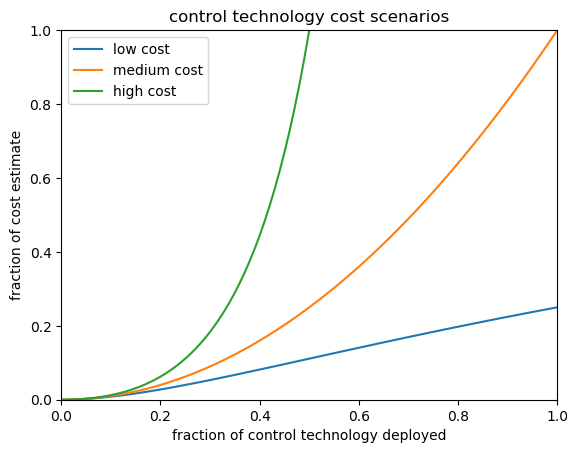

PyObject <matplotlib.legend.Legend object at 0x1470bad30>

In [5]:
x = 0:0.01:1.

y_low = (x./(1. .+x)).^2
y_med = x.^2
y_high = (x./(1. .-x)).^2
title("control technology cost scenarios")
plot(x,y_low, label="low cost")
plot(x,y_med, label="medium cost")
plot(x,y_high, label="high cost")
xlim([0,1])
ylim([0,1])
ylabel("fraction of cost estimate")
xlabel("fraction of control technology deployed")
legend()

In [6]:
c(ϕ::Array, φ::Array) = c_0 .- cumsum(q .* φ) .- cumsum(q[1] .* ϕ);
δT(ϕ::Array, φ::Array) = δT_00 .+ ϵ.*log.(c(ϕ,φ)./c_00);

D(ϕ::Array, φ::Array, χ::Array, λ::Array) = (1. .- χ) .* β .* δT(ϕ, φ).^2 .* (1. .- λ).^2;

C(ϕ::Array, φ::Array, χ::Array, λ::Array) = C_λ.*f_low(λ) .+ C_ϕ.*f_low(ϕ) .+ C_φ.*f_low(φ) .+ C_χ.*f_low(χ);
T(ϕ::Array, φ::Array, χ::Array, λ::Array) = (
    sum((C(ϕ, φ, χ, λ) .+ D(ϕ, φ, χ, λ)) .* (1. / (1. + ρ)).^(t.-t[1])) .+
    200. * (sum(diff(ϕ).^2) .+ sum(diff(φ).^2) .+ sum(diff(χ).^2) .+ sum(diff(λ).^2)) .+
    200. .* (ϕ[1].^2 .+ φ[1].^2 .+ χ[1].^2 .+ λ[1].^2)
);

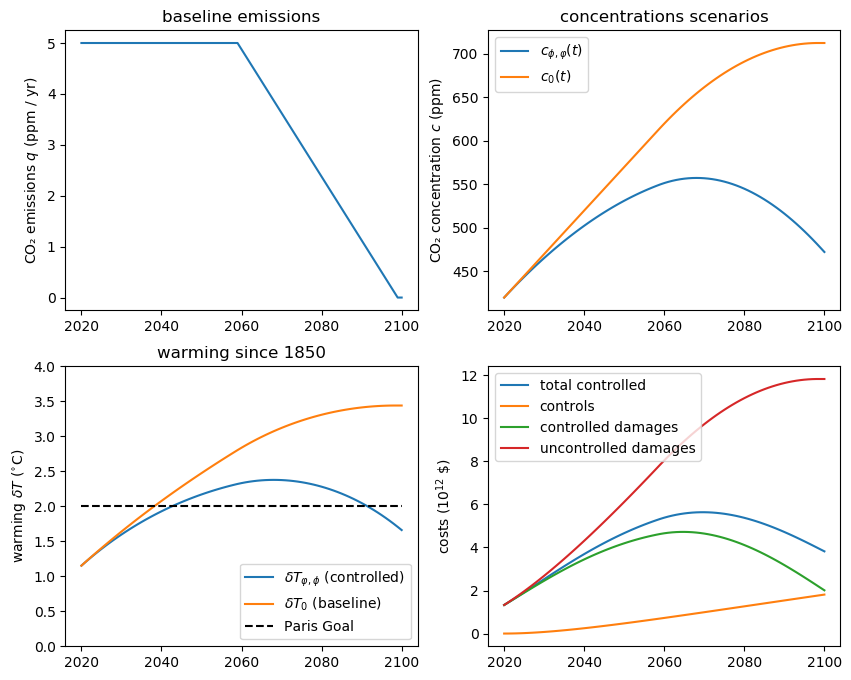

PyObject <matplotlib.legend.Legend object at 0x147892198>

In [7]:
figure(figsize=(10,8))
subplot(2,2,1)
plot(t,q)
ylabel(L"CO₂ emissions $q$ (ppm / yr)")
title("baseline emissions")

subplot(2,2,2)
plot(t,c(ϕ,φ), label=L"$c_{\phi,\varphi}(t)$")
plot(t,c_0, label=L"$c_{0}(t)$")
legend()
ylabel(L"CO₂ concentration $c$ (ppm)")
title("concentrations scenarios")

subplot(2,2,3)
plot(t,δT(ϕ, φ), label=L"$\delta T_{\varphi,\phi}$ (controlled)")
plot(t,δT_0, label=L"$\delta T_{0}$ (baseline)")
plot(t,2.0.*ones(size(t)),"k--", label="Paris Goal")
ylabel(L"warming $δT$ ($^{\circ}$C)")
ylim([0,4.0])
legend()
title("warming since 1850")

subplot(2,2,4)
plot(t, C(ϕ, φ, χ, λ) + D(ϕ, φ, χ, λ), label="total controlled")
plot(t, C(ϕ, φ, χ, λ), label="controls")
plot(t, D(ϕ, φ, χ, λ), label="controlled damages")
plot(t, D_0, label="uncontrolled damages")
ylabel(L"costs (10$^{12}$ \$)")
legend()

## Gradient descent cost minimization

In [8]:
function ∇T(ϕ::Array, φ::Array, χ::Array, λ::Array)
    Δα = 1.e-5
    ∂T∂ϕ = zeros(size(ϕ))
    ∂T∂φ = zeros(size(φ))
    ∂T∂χ = zeros(size(χ))
    ∂T∂λ = zeros(size(λ))
    for i=1:length(ϕ)
        δα = zeros(size(ϕ))
        δα[i] = Δα
        ∂T∂ϕ[i] = (T(ϕ.+δα,φ,χ,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂φ[i] = (T(ϕ,φ.+δα,χ,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂χ[i] = (T(ϕ,φ,χ.+δα,λ) .- T(ϕ,φ,χ,λ))/Δα
        ∂T∂λ[i] = (T(ϕ,φ,χ,λ.+δα) .- T(ϕ,φ,χ,λ))/Δα
    end
    
    return (∂T∂ϕ, ∂T∂φ, ∂T∂χ, ∂T∂λ)
end

function convergence(∇T, tol = 1.e-6)
    norm = 0.
    for ∂T∂α = ∇T
        norm += sum(∂T∂α.^2)
    end
    return norm < tol
end

convergence (generic function with 2 methods)

In [9]:
count = 1
while convergence(∇T(ϕ, φ, χ, λ), 1.e-8) == false
    ∇ = ∇T(ϕ, φ, χ, λ)
    norm = 0.
    for ∂T∂α = ∇
        norm += sum(∂T∂α.^2)
    end
    print(norm, " ")
    Δs = 5.e-4
    ϕ .-= ∇[1].*Δs
    φ .-= ∇[2].*Δs
    χ .-= ∇[3].*Δs
    λ .-= ∇[4].*Δs
    count+=1
    
    if count>1000
        break
    end
end

1178.5869942892075 1088.2740152374854 1034.7365211090262 993.5596836530947 958.4965257010463 927.2237247358355 898.6359558321162 872.1152290381503 847.2752550505568 823.8542117895599 801.6634491317291 780.560473098749 760.4335486715711 741.1924118456498 722.7623314698346 705.0802116738853 688.0918818535515 671.7502013777448 656.013661472691 640.8453564451819 626.212205362468 612.0843254244447 598.4345720682602 585.2381410767327 572.4722738560678 560.1159866896799 548.1498714797061 536.5559133361264 525.3173428061277 514.4185135237999 503.84478404462857 493.5824280097322 483.6185499916554 473.94101745432135 464.5383938712928 455.3998842890893 446.51527507362744 437.874908280446 429.4696267978951 421.29073970424577 413.3299959756888 405.57954842657784 398.03192775059136 390.6800260441828 383.51706056226783 376.5365652810341 369.73236260632905 363.0985545133665 356.62949870832017 350.31980007970554 344.1642910620196 338.1580275092223 332.2962645471148 326.5744576524569 320.9882441389756 3

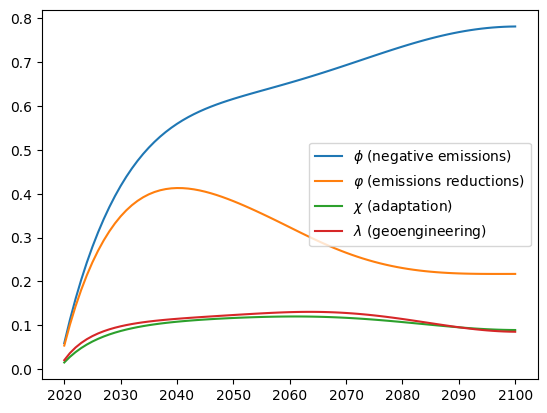

PyObject <matplotlib.legend.Legend object at 0x147fce0b8>

In [10]:
plot(t, ϕ, label=L"$\phi$ (negative emissions)")
plot(t, φ, label=L"$\varphi$ (emissions reductions)")
plot(t, χ, label=L"$\chi$ (adaptation)")
plot(t, λ, label=L"$\lambda$ (geoengineering)")
legend()

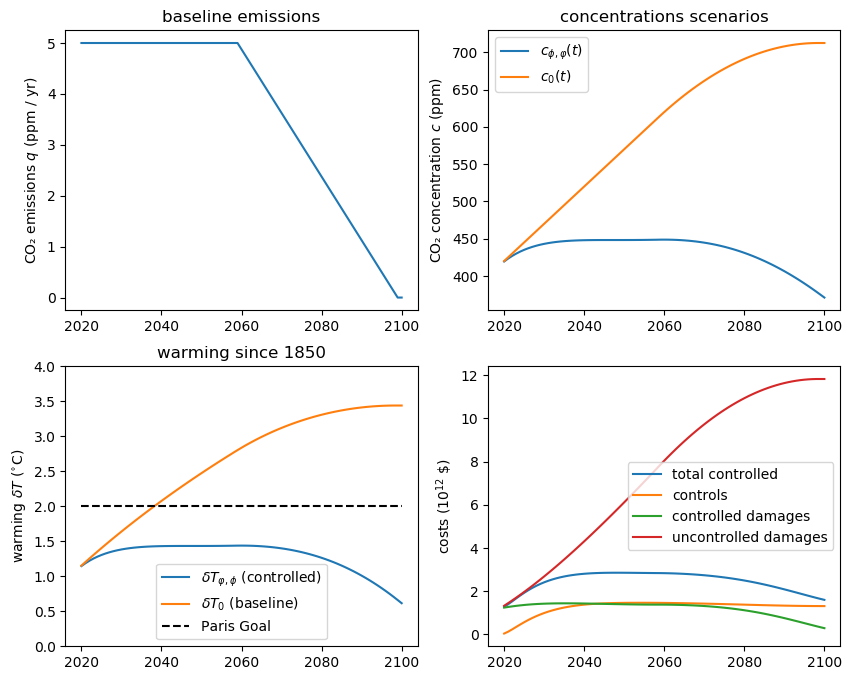

PyObject <matplotlib.legend.Legend object at 0x14818d860>

In [11]:
figure(figsize=(10,8))
subplot(2,2,1)
plot(t,q)
ylabel(L"CO₂ emissions $q$ (ppm / yr)")
title("baseline emissions")

subplot(2,2,2)
plot(t,c(ϕ,φ), label=L"$c_{\phi,\varphi}(t)$")
plot(t,c_0, label=L"$c_{0}(t)$")
legend()
ylabel(L"CO₂ concentration $c$ (ppm)")
title("concentrations scenarios")

subplot(2,2,3)
plot(t,δT(ϕ, φ), label=L"$\delta T_{\varphi,\phi}$ (controlled)")
plot(t,δT_0, label=L"$\delta T_{0}$ (baseline)")
plot(t,2.0.*ones(size(t)),"k--", label="Paris Goal")
ylabel(L"warming $δT$ ($^{\circ}$C)")
ylim([0,4.0])
legend()
title("warming since 1850")

subplot(2,2,4)
plot(t, C(ϕ, φ, χ, λ) + D(ϕ, φ, χ, λ), label="total controlled")
plot(t, C(ϕ, φ, χ, λ), label="controls")
plot(t, D(ϕ, φ, χ, λ), label="controlled damages")
plot(t, D_0, label="uncontrolled damages")
ylabel(L"costs (10$^{12}$ \$)")
legend()